In [1]:
%matplotlib inline
import scipy
import matplotlib.pyplot as plt
import numpy as np
import palettable
from matplotlib.colors import LinearSegmentedColormap
from fipy import CellVariable, ConvectionTerm, DiffusionTerm, TransientTerm
from fipy.meshes.uniformGrid1D import UniformGrid1D
from palettable.colorbrewer.diverging import RdYlBu_6, RdYlBu_5, RdYlBu_4
from palettable.colorbrewer.qualitative import  Pastel1_5, Set1_5, Set2_4

from matplotlib import rc
rc('font',**{'family':'serif','sans-serif':['Helvetica']})
rc('text', usetex=True)

/Users/rmcgibbo/miniconda/envs/2.7/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


First, create a discrete mesh.

In [2]:
xmin, xmax = -2., 2.
Nx = 100.
mesh = UniformGrid1D(dx=(xmax-xmin)/Nx, nx=Nx, origin=(xmin,))
print(mesh.cellCenters[0])

[-1.98 -1.94 -1.9  -1.86 -1.82 -1.78 -1.74 -1.7  -1.66 -1.62 -1.58 -1.54
 -1.5  -1.46 -1.42 -1.38 -1.34 -1.3  -1.26 -1.22 -1.18 -1.14 -1.1  -1.06
 -1.02 -0.98 -0.94 -0.9  -0.86 -0.82 -0.78 -0.74 -0.7  -0.66 -0.62 -0.58
 -0.54 -0.5  -0.46 -0.42 -0.38 -0.34 -0.3  -0.26 -0.22 -0.18 -0.14 -0.1
 -0.06 -0.02  0.02  0.06  0.1   0.14  0.18  0.22  0.26  0.3   0.34  0.38
  0.42  0.46  0.5   0.54  0.58  0.62  0.66  0.7   0.74  0.78  0.82  0.86
  0.9   0.94  0.98  1.02  1.06  1.1   1.14  1.18  1.22  1.26  1.3   1.34
  1.38  1.42  1.46  1.5   1.54  1.58  1.62  1.66  1.7   1.74  1.78  1.82
  1.86  1.9   1.94  1.98]


In [3]:
# A CellVariable on the mesh stores a field.
p = CellVariable(name="p", mesh=mesh, value=0.)

In [4]:
x = mesh.cellCenters
# Potential
E = (x-1)**2*(x+1)**2
# Gradient of Potential
grad = 2*((x-1)*(x+1)**2 + (x-1)**2*(x+1))
force = CellVariable(name='force', mesh=mesh, value=grad)

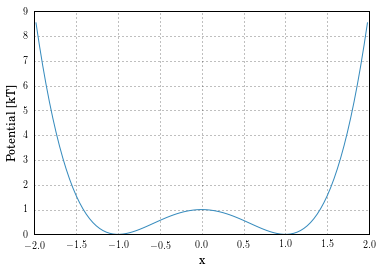

In [5]:
plt.plot(np.asarray(x[0]), np.asarray(E[0]))
plt.xlabel('x')
plt.ylabel('Potential [kT]')

$$
\frac{dp(x,t)}{dt} = - \frac{d}{dx} (\nabla U(x) p(x,t)) + \Delta (D p(x,t))
$$

$$
\frac{dp(x,t)}{dt} = \frac{d}{dx} (F(x) \, p(x,t)) + \frac{d^2}{dx^2} (D p(x,t))
$$

In [6]:
D = 1.  # constant diffusion coefficient
eq = TransientTerm() == ConvectionTerm(coeff=force) +  DiffusionTerm(coeff=D)

In [7]:
# Calculate the stiffness matrix
eq.cacheMatrix()
eq.sweep(var=p, dt=1)
A = eq.matrix.numpyArray
print(A.shape)

(100, 100)


/Users/rmcgibbo/miniconda/envs/2.7/lib/python2.7/site-packages/fipy/solvers/scipy/linearLUSolver.py:71: RuntimeWarning: invalid value encountered in double_scalars
  if (numerix.sqrt(numerix.sum(errorVector**2)) / error0)  <= self.tolerance:


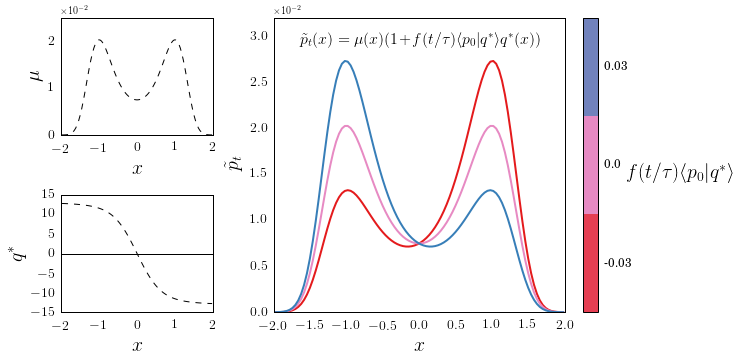

In [8]:
plt.figure(figsize=(12,7))

ax1 = plt.subplot2grid((3,4), (0, 0), colspan=1)
ax2 = plt.subplot2grid((3,4), (1, 0), rowspan=1)
ax3 = plt.subplot2grid((3,4), (0, 1), rowspan=2, colspan=2)

w, vl, vr = scipy.linalg.eig(-eq.matrix.numpyArray, left=True, right=True)
index = np.argsort(w)

plotx = np.asarray(mesh.cellCenters[0])
mu = vr[:,index[-1]] / np.sum(vr[:,index[-1]])
q = vl[:,index[-2]]
q = q / np.sum(q*q*mu)


ax1.plot(plotx, mu, 'k--', label='$\mu$')
ax1.set_xlabel(r'$x$', fontsize=20)
ax1.set_ylabel(r'$\mu$', fontsize=20)
ax1.set_xticks([-2, -1, 0, 1, 2])
ax1.set_yticks([0.0, 0.01, 0.02])


ax2.plot(plotx, q, 'k--', label='q')
ax2.set_xlabel(r'$x$', fontsize=20)
ax2.set_ylabel(r'$q^*$', fontsize=20)
ax2.plot(plotx, [0]*len(plotx), 'k')
ax2.set_xticks([-2, -1, 0, 1, 2])

colors = [Set1_5.mpl_colors[0], Set2_4.mpl_colors[3], Set1_5.mpl_colors[1]]

coeffs = np.array([-3.0, 0, 3.0]) / 100
Z = [[0,0], [0,0]]

CS3 = ax3.contourf(Z, [0,1,2,3], cmap=LinearSegmentedColormap.from_list('mymap', colors))
ax3.cla()

for i, coeff in enumerate(coeffs):
    ax3.plot(plotx, mu * (1+coeff*q), color=colors[i], lw=2)


cbar = plt.colorbar(CS3)
cbar.set_label(r'$f(t/\tau)\langle p_0 | q^* \rangle$', rotation=0, fontsize=20, labelpad=50)

ax3.set_xlabel(r'$x$', fontsize=20, rotation=0)
yl = ax3.set_ylabel(r'$\tilde{p}_t$', fontsize=20)

ax1.grid(False)
ax2.grid(False)
ax3.grid(False)

for ax in [ax1, ax2, ax3]:
    for tick in ax.xaxis.get_major_ticks():
        tick.label.set_fontsize(14) 
    for tick in ax.yaxis.get_major_ticks():
        tick.label.set_fontsize(14) 


ax1.ticklabel_format(style='sci',scilimits=(0,0), axis='y')
ax3.ticklabel_format(style='sci',scilimits=(0,0), axis='y')
ax3.set_ylim(0, 0.032)
ax.annotate(r"$\tilde{p}_t(x) = \mu(x)(1\!+\!f(t/\tau)\langle p_0|q^*\rangle q^*(x))$", xy=(0.5, 0.92), xycoords="axes fraction", fontsize=16, va="center", ha="center",)

labels = np.array([-3, 0, 3]) / 100.0
cbar.set_ticks([0.5,1.5,2.5])
cbar.set_ticklabels(map(str, labels))
cbar.ax.tick_params(labelsize=12)
plt.tight_layout()
plt.subplots_adjust(wspace=0.4)
plt.savefig('doublewell-figure.pdf')

In [9]:
!pdfcrop --margins 20 doublewell-figure.pdf

PDFCROP 1.38, 2012/11/02 - Copyright (c) 2002-2012 by Heiko Oberdiek.
==> 1 page written on `doublewell-figure-crop.pdf'.
